# ATMS 523 Homework 6
## Wenhan Tang (UIN: 678054985)

### 1. Aggregate the tornado data over the following states into a monthly count of tornadoes: Illinois

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import shap

In [2]:
df = pd.read_csv("1950-2021_actual_tornadoes.csv")
df_illinois = df[ df["st"] == "IL" ].copy()
df_illinois["date"] = pd.to_datetime(df_illinois["date"])
df_illinois["year_month"] = df_illinois["date"].dt.to_period("M")

df_illinois_monthly = df_illinois.groupby("year_month").size()

df_illinois_monthly = df_illinois_monthly.reindex(
    pd.period_range(
        df_illinois_monthly.index.min(),
        df_illinois_monthly.index.max(),
        freq='M'
    ),
    fill_value=0
).reset_index(name="tornados")
df_illinois_monthly = df_illinois_monthly.rename(columns = {"index": "year_month"})
df_illinois_monthly

,year_month,tornados
0,1950-01,2
1,1950-02,0
2,1950-03,1
3,1950-04,0
4,1950-05,0
...,...,...
859,2021-08,16
860,2021-09,0
861,2021-10,10
862,2021-11,0


### 2. Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

In [3]:
df_ts = pd.read_csv("ts_data2.csv").reset_index()
df_ts = df_ts.rename(columns={"Date": "date"})
df_ts = df_ts[["date", "ENSO", "PDO", "NAO", "AO"]]
df_ts["date"] = pd.to_datetime(df_ts["date"])
df_ts["year_month"] = df_ts["date"].dt.to_period("M")
df_ts

,date,ENSO,PDO,NAO,AO,year_month
0,1854-01-01,NaN,0.11,NaN,NaN,1854-01
1,1854-02-01,NaN,-0.24,NaN,NaN,1854-02
2,1854-03-01,NaN,-0.40,NaN,NaN,1854-03
3,1854-04-01,NaN,-0.44,NaN,NaN,1854-04
4,1854-05-01,NaN,-0.54,NaN,NaN,1854-05
...,...,...,...,...,...,...
2059,2025-08-01,0.4,-3.20,0.26,0.036,2025-08
2060,2025-09-01,0.0,-2.33,-0.80,0.048,2025-09
2061,2025-10-01,-99.9,-2.40,-0.96,0.064,2025-10
2062,2025-11-01,-99.9,99.99,NaN,NaN,2025-11


In [4]:
df_merged = df_illinois_monthly.merge(df_ts[["year_month", "ENSO", "PDO", "NAO", "AO"]], on="year_month", how="left")
df_merged["year_month"] = df_merged["year_month"].dt.to_timestamp()
df_merged = df_merged.set_index("year_month")
df_merged

,tornados,ENSO,PDO,NAO,AO
year_month,,,,,
1950-01-01,2,NaN,-1.61,0.92,-0.060
1950-02-01,0,NaN,-2.17,0.40,0.627
1950-03-01,1,NaN,-1.89,-0.36,-0.008
1950-04-01,0,NaN,-1.99,0.73,0.555
1950-05-01,0,NaN,-3.19,-0.59,0.072
...,...,...,...,...,...
2021-08-01,16,0.6,-0.95,-0.28,-0.209
2021-09-01,0,0.8,-1.96,-0.21,-0.252
2021-10-01,10,0.7,-3.13,-2.29,-0.146


### 3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes. Create a scatter plot of the predicted and observed number of tornadoes over these states. Report the correlation coefficient and RMSE of your model.

In [5]:
df_Xy = df_merged.dropna()
X = df_Xy[["ENSO", "PDO", "NAO", "AO"]]
y = df_Xy["tornados"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [6]:
model_RF = RandomForestRegressor(
    n_estimators = 1000,
    max_depth = 10,
    bootstrap = True,
    random_state = 0,
)
model_RF.fit(X_train, y_train.values)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


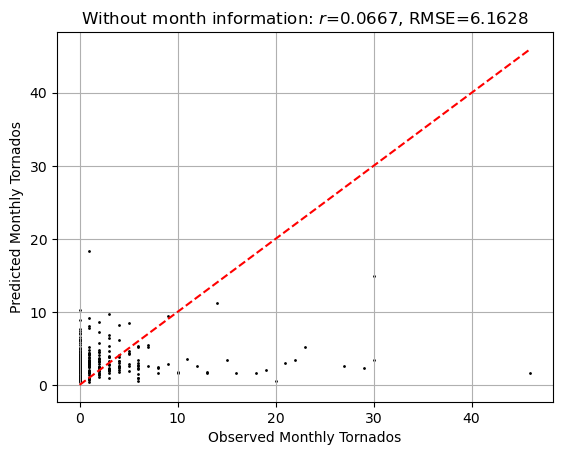

In [7]:
y_pred = model_RF.predict(X_test)
rr = np.corrcoef(y_pred, y_test.values)[0,1]
rmse = np.sqrt(mean_squared_error(y_pred, y_test.values))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_test.values, y_pred, s=1, c="black")
min_range = min(y_test.values.min(), y_pred.min())
max_range = max(y_test.values.max(), y_pred.max())
ax.plot([min_range, max_range], [min_range, max_range], color="red", linestyle="dashed")
ax.grid()
ax.set_xlabel("Observed Monthly Tornados")
ax.set_ylabel("Predicted Monthly Tornados")
ax.set_title(f"Without month information: $r$={rr:.4f}, RMSE={rmse:.4f}")
plt.show()

### 4. Create a one-hot encoding for the month of the year. Repeat the scatterplot and compare the RMSE and correlation coefficient values.

In [8]:
months = df_Xy.index.month
onehot_month = pd.get_dummies(months, prefix="month", drop_first=False)
onehot_month.index = df_Xy.index
X = X.merge(onehot_month, left_index=True, right_index=True, how="left")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [9]:
model_RF_month = RandomForestRegressor(
    n_estimators = 1000,
    max_depth = 10,
    bootstrap = True,
    random_state = 0,
)
model_RF_month.fit(X_train, y_train.values)

,n_estimators,1000
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


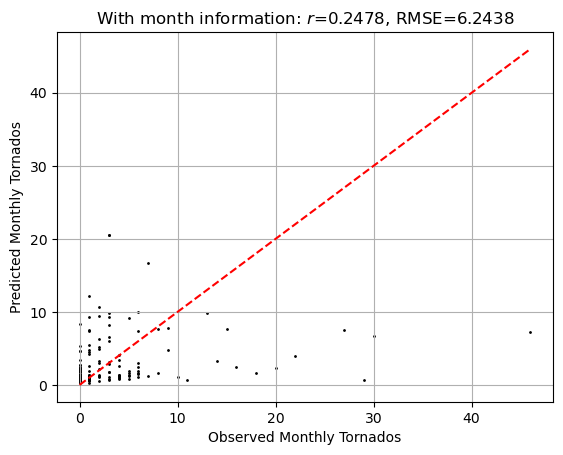

In [10]:
y_pred = model_RF_month.predict(X_test)
rr = np.corrcoef(y_pred, y_test.values)[0,1]
rmse = np.sqrt(mean_squared_error(y_pred, y_test.values))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_test.values, y_pred, s=1, c="black")
min_range = min(y_test.values.min(), y_pred.min())
max_range = max(y_test.values.max(), y_pred.max())
ax.plot([min_range, max_range], [min_range, max_range], color="red", linestyle="dashed")
ax.grid()
ax.set_xlabel("Observed Monthly Tornados")
ax.set_ylabel("Predicted Monthly Tornados")
ax.set_title(f"With month information: $r$={rr:.4f}, RMSE={rmse:.4f}")
plt.show()

### 5. Perform a feature importance and multipass permutation analysis of your features

Text(0.5, 1.0, 'Feature importance for random forest model (with month information)')

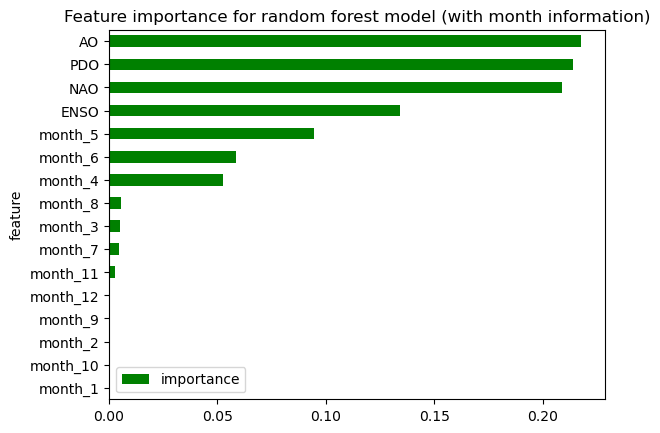

In [11]:
df_importance = pd.DataFrame({
    "feature": X_test.columns,
    "importance": model_RF_month.feature_importances_,
})
df_importance = df_importance.sort_values("importance", ascending=True)
ax = df_importance.plot.barh(x="feature", y="importance", color="green")
ax.set_title("Feature importance for random forest model (with month information)")

In [12]:
result = permutation_importance(
    model_RF_month, X_test, y_test, n_repeats=20, random_state=0, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

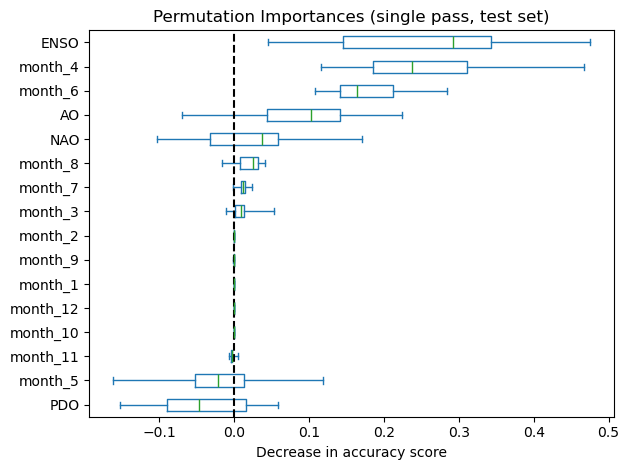

In [13]:
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (single pass, test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [14]:
def multipass_permutation_analysis(model, X_, y_, n_pass):
    
    X = X_.copy()
    y = y_.copy()
    rng = np.random.default_rng(0)
    
    feature_total = list(X.columns)
    analysis_results = []
                    
    y_pred = model.predict(X)
    R2_base = r2_score(y.values, y_pred)
    rmse_base = np.sqrt(mean_squared_error(y_pred, y.values))

    
    for i_pass in range(n_pass):
        #print("Pass %d" % (i_pass + 1))
        result = permutation_importance(model, X, y, n_repeats=20, random_state=0, n_jobs=2)
        mean_importance = result.importances_mean
        top_important_feature_idx = np.argmax(mean_importance)
        top_important_feature = feature_total[top_important_feature_idx]
        X[top_important_feature] = rng.permutation(X[top_important_feature].values)
        
        y_pred = model.predict(X)
        R2 = r2_score(y.values, y_pred)
        rmse = np.sqrt(mean_squared_error(y_pred, y.values))
        analysis_results.append({
            "i_pass": i_pass+1,
            "top_important_feature": top_important_feature,
            "R2_diff": R2 - R2_base,
            "RMSE_diff": rmse - rmse_base,
        })
    return analysis_results

def results_to_df(analysis_results):
    i_pass = []
    dic = {
        "top_important_feature": [],
        "R2_diff": [],
        "RMSE_diff": [],
    }
    for res in analysis_results:
        i_pass.append(res["i_pass"])
        dic["top_important_feature"].append(res["top_important_feature"])
        dic["R2_diff"].append(res["R2_diff"])
        dic["RMSE_diff"].append(res["RMSE_diff"])

    df = pd.DataFrame(dic, index=i_pass)
    return df


In [15]:
analysis_results = multipass_permutation_analysis(model_RF_month, X_test, y_test, n_pass = 10)
analysis_results = results_to_df(analysis_results)
analysis_results

,top_important_feature,R2_diff,RMSE_diff
1,ENSO,-0.000988,0.002977
2,month_4,-0.263028,0.747799
3,month_6,-0.410864,1.134908
4,AO,-0.348576,0.974337
5,AO,-0.517427,1.401796
6,month_8,-0.555517,1.494963
7,month_3,-0.563629,1.514658
8,month_8,-0.565003,1.517989
9,month_2,-0.565354,1.518842
10,month_1,-0.565365,1.518868


### 6. Create a SHAP Summary Plot showing feature importance and feature effects.

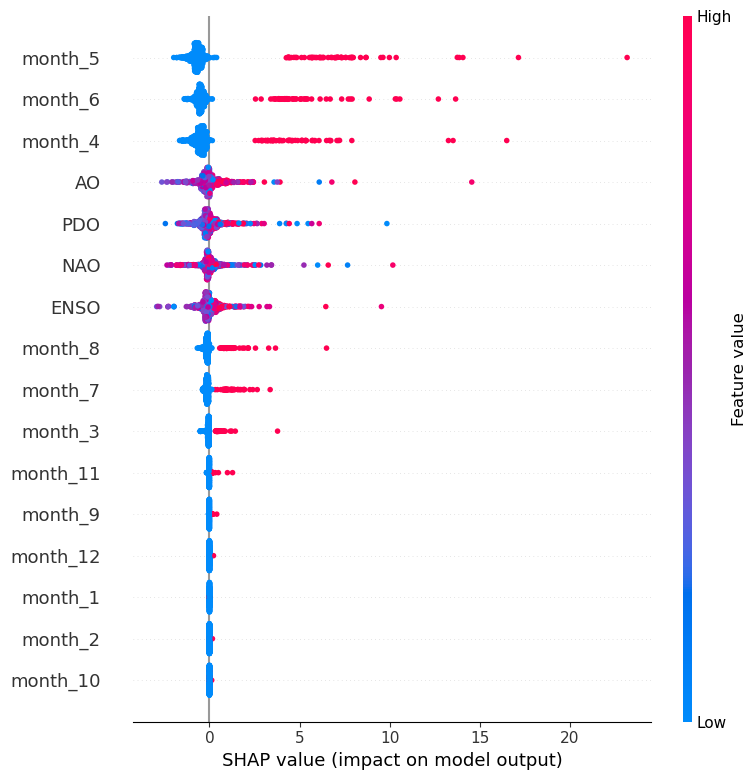

In [18]:
X_data = X_train
explainer_RF_month = shap.TreeExplainer(model_RF_month)
explain_values = explainer_RF_month.shap_values(X_data)
shap.summary_plot(explain_values, X_data)

### 7. Create a SHAP Feature Dependence for the ENSO index.

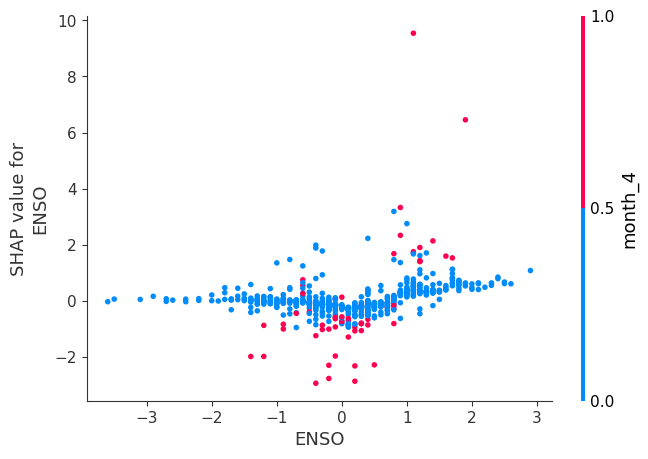

In [19]:
shap.dependence_plot("ENSO", explain_values, X_data)

### 8. Any observations on the importance of the various features in your model from the XAI techniques you tried?

1. Overall, the large-scale circulation indices all make substantial contributions to the model’s predictions. Their effects are likely nonlinear and may involve complex synergistic interactions.

2. Compared with the circulation indices, the influence of month-of-year is smaller. However, whether a sample falls within April–June does noticeably affect the model’s output, and this effect appears to be more “linear”—the model tends to predict higher tornado counts during these peak-season months.

3. The relationship between ENSO and tornado activity further depends on whether the month is April. Outside of April, both El Niño and La Niña conditions are associated with increased tornado counts. In contrast, during April, El Niño tends to enhance tornado occurrence, whereas La Niña may suppress it.